In [1]:
%matplotlib inline
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx

# import our own functions
from our_functions import get_true_labels, find_components, find_largest_component, \
give_names_tonodes_dates_based, num_nodes, connected_graph, compute_shortest_path_lengths
import random

# Extracting Terrorist Names from Nodes

In [2]:
A = np.load('adjacency.npy')

# get the largest component
A, size = find_largest_component(find_components(A))

n_nodes = size
n_edges = np.count_nonzero(A) / 2

# get terrorist names for each node
names, A, name_dict = give_names_tonodes_dates_based(A)

# get relation label for each node
labels = get_true_labels(A)

# Graph Inversion

Number of unique terrorist: 244


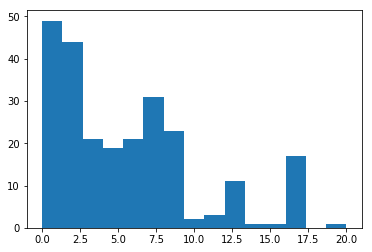

In [3]:
# Number of unique terrorists
num_terrorist = len(name_dict.keys())
print("Number of unique terrorist: {n:}".format(n=num_terrorist))

# Array of terrorist names 
all_names = np.array(list(name_dict.keys()))

# Initialize inverted adjacency matrix. Symmetric and unweighted by default.
A_inverted = np.zeros((num_terrorist, num_terrorist))
A_relations = np.zeros((num_terrorist, num_terrorist))

for n in range(n_nodes):
    temp = []
    for d, name in enumerate(list(name_dict.keys())):
        if n in list(name_dict.values())[d]:
            # collect all terrorist names that correspond to node n: will ALWAYS be at most length 2
            temp.append(list([name]))

    for k in range(len(temp)):
        for j in range(len(temp)):
            if k >= j: continue
            idx = np.where(all_names == temp[k])[0][0]
            idx2 = np.where(all_names == temp[j])[0][0]
            
            # create an edge between all terrorists that belonged to the same node in original graph
            A_inverted[idx,idx2] = 1
            A_inverted[idx2,idx] = 1
            
            # create a matrix which stores corresponding relations between terrorists             
            A_relations[idx,idx2] = int(labels[n])
            A_relations[idx2,idx] = int(labels[n])
            
plt.hist(np.sum(A_inverted,axis=1), bins=15)
plt.show()

### Largest Component of Inverted Graph

Number of disconnected components: 30


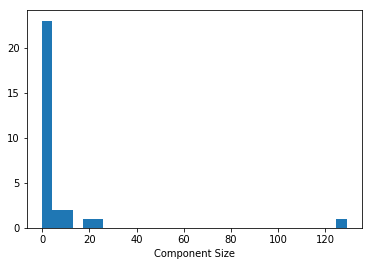

Size of inverted graph: 244
Size of largest component: 129


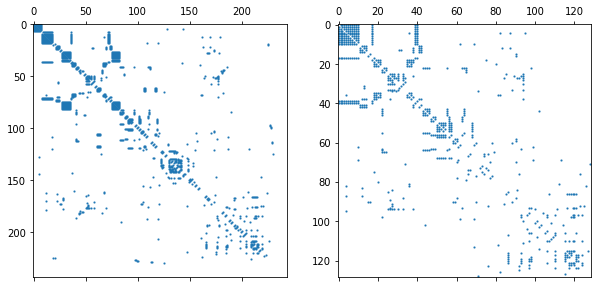

In [4]:
# Find the largest component
components = find_components(A_inverted)
largest_cc_inv, size = find_largest_component(components)

# Remove all-zero indices
zero_index = np.where(np.sum(largest_cc_inv, axis=0) == 0)[0]
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=0)
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=1)
relations_largest_cc = np.delete(A_relations, zero_index, axis=0)
relations_largest_cc = np.delete(relations_largest_cc, zero_index, axis=1)
names_largest_cc = np.delete(all_names, zero_index)

print("Number of disconnected components: {d:}".format(d=len(components)))
deg_dist = []
for c in range(len(components)):
    deg_dist.append(num_nodes(components[c]))

plt.hist(deg_dist, bins=len(components))
plt.xlabel('Component Size')
plt.show()

print("Size of inverted graph: {s:}".format(s=num_terrorist))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.spy(A_inverted, markersize=1)

print("Size of largest component: {s:}".format(s=size))
ax2 = fig.add_subplot(122)
ax2.spy(largest_cc_inv, markersize=1)

In [5]:
display = False
if display:
    for idx, name in enumerate(names):
        print(name)
        for i in range(A.shape[0]):
            if A[idx, i] == 1:
                print("\t"+str(names[i]))

# Identify Key Players for Fragmenting Network
In this section, we identify a set of key players that structurally destorys, or fragments, the network the most when removed. Metrics that help us evaluate this property include (all normalized except information entropy):
- count of number of disconnected components (+)
- F measure, count of number of pairs of nodes that are disconnected (+)
- Information entropy (+)
- Fd measure, modification of F measure which takes into account internal structure (+)

(+) = the higher, the more important that node is

Source: http://steveborgatti.com/papers/cmotkeyplayer.pdf

### Agenda
3. If YES, compare a single problem of multi-objective problem vs. mutual terrorists of multiple single-objective problems (using the paper's greedy algorithm with k=5).
4. From 3 (a), if same results, implement multi-objective problem b/c that's simpler. If different results, try & understand why and decide which is better.
5. Do step 3 with the section below.
6. From 4, if multi-objective problem is better, implement clustering algorithhm and then the greedy algorithm. See if this is faster AND outputs the same result.
7. From 6, if the addition of clustering gives the same result AND is faster, do this. If different results, try & understand why and decide which is better.

In [50]:
from copy import deepcopy
from tqdm import tqdm_notebook

def num_disconnected_components(adjacency):
    """
    Parameters
    ----------
    adjacency: numpy matrix representing the adjacency matrix of the network.\
    Assumes connected.
    
    Returns
    -------
    num_dis: a vector of integers, \
    representing the number of disconnected components resulted from removing one node at a time
    """
    
    num_dis = np.empty(adjacency.shape[0])
    for n in range(adjacency.shape[0]):
        temp = deepcopy(adjacency)
        temp[n,:] = 0
        temp[:,n] = 0
        zero_index = np.where(np.sum(temp, axis=0) == 0)[0]
        temp = np.delete(temp, zero_index, axis=0)
        temp = np.delete(temp, zero_index, axis=1)

        # Number of disconnected components normalized by the size of original network
        num_dis[n] = len(find_components(temp)) / adjacency.shape[0]
    return num_dis


def F_measure(adjacency):
    """
    Parameters
    ----------
    adjacency: numpy matrix representing the adjacency matrix of the network.\
        
    Returns
    -------
    If kwarges == None
        F_measure: a vector of floats between 0 and 1, \
        representing the number of disconnected pairs of nodes resulted from removing one node at a time
    
    Otherwise F_measure is a single float between 0 and 1
    """
    
    original_size = adjacency.shape[0]  
    
    F_measure = np.empty(original_size)
    for n in range(original_size):
        temp = deepcopy(adjacency)
        temp[n,:] = 0
        temp[:,n] = 0
        zero_index = np.where(np.sum(temp, axis=0) == 0)[0]
        temp = np.delete(temp, zero_index, axis=0)
        temp = np.delete(temp, zero_index, axis=1)

        components = find_components(temp)
        numerator = 0
        for k in range(len(components)):
            s_k = num_nodes(components[k])
            numerator += s_k * (s_k - 1)
    
        F_measure[n] = 1 - numerator / (original_size * (original_size - 1))
    return F_measure


def information_entropy(adjacency):
    """
    Parameters
    ----------
    adjacency: numpy matrix representing the adjacency matrix of the network.
    
    Returns
    -------
    entropy: a vector of floats between 0 and 1, \
    representing information entropy resulted from removing one node at a time
    """
    
    original_size = adjacency.shape[0]
    entropy = np.empty(original_size)
    for n in range(original_size):
        temp = deepcopy(adjacency)
        temp[n,:] = 0
        temp[:,n] = 0
        zero_index = np.where(np.sum(temp, axis=0) == 0)[0]
        temp = np.delete(temp, zero_index, axis=0)
        temp = np.delete(temp, zero_index, axis=1)

        components = find_components(temp)
        numerator = 0
        for k in range(len(components)):
            s_k = num_nodes(components[k])
            numerator += (s_k / original_size) * np.log(s_k / original_size)

        entropy[n] = -numerator
    return entropy


def Fd_measure(adjacency):
    """
    Parameters
    ----------
    adjacency: numpy matrix representing the adjacency matrix of the network.
    
    Returns
    -------
    Fd: a vector of floats between 0 and 1, \
    representing number of disconnected pairs of nodes, accounting for internal structure,\
    resulted from removing one node at a time
    """
    
    Fd = np.empty(adjacency.shape[0])
    denominator = (adjacency.shape[0]-1) * (adjacency.shape[0]-2) / 2
    for n in tqdm_notebook(range(adjacency.shape[0])):
        temp = deepcopy(adjacency)
        temp[n,:] = 0
        temp[:,n] = 0
        zero_index = np.where(np.sum(temp, axis=0) == 0)[0]
        temp = np.delete(temp, zero_index, axis=0)
        temp = np.delete(temp, zero_index, axis=1)

        numerator = 0
        for i in range(temp.shape[0]):
            shortest_paths_lengths = compute_shortest_path_lengths(temp, i)
            for j in range(temp.shape[0]):
                if i <= j: continue
                numerator += 1 / shortest_paths_lengths[j]

        Fd[n] =  1 - numerator / denominator
    return Fd

num_dis = num_disconnected_components(largest_cc_inv)
F = F_measure(largest_cc_inv)
entropy = information_entropy(largest_cc_inv)
Fd = Fd_measure(largest_cc_inv) # will display a progress bar

### Boxplots visualization of "fragmentation" measures

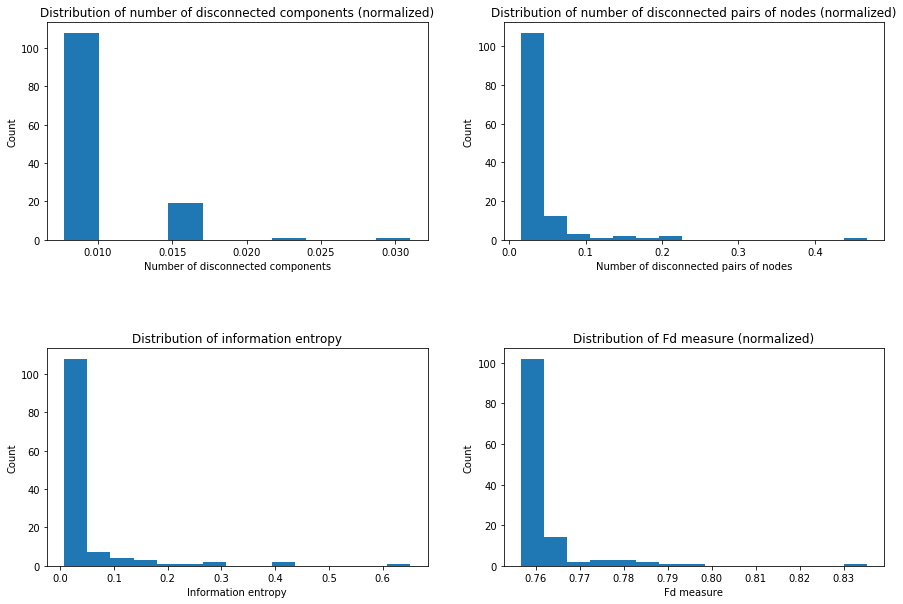

In [7]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax1.hist(num_dis, bins=10)
ax1.set_xlabel("Number of disconnected components")
ax1.set_ylabel("Count")
ax1.set_title("Distribution of number of disconnected components (normalized)")

ax2 = fig.add_subplot(222)
ax2.hist(F, bins=15)
ax2.set_xlabel("Number of disconnected pairs of nodes")
ax2.set_ylabel("Count")
ax2.set_title("Distribution of number of disconnected pairs of nodes (normalized)")

plt.subplots_adjust(hspace=0.5)

ax3 = fig.add_subplot(223)
ax3.hist(entropy, bins=15)
ax3.set_xlabel("Information entropy")
ax3.set_ylabel("Count")
ax3.set_title("Distribution of information entropy")

ax4 = fig.add_subplot(224)
ax4.hist(Fd, bins=15)
ax4.set_xlabel("Fd measure")
ax4.set_ylabel("Count")
ax4.set_title("Distribution of Fd measure (normalized)")
plt.show()

### Determine if any of the above measures are positively correlated

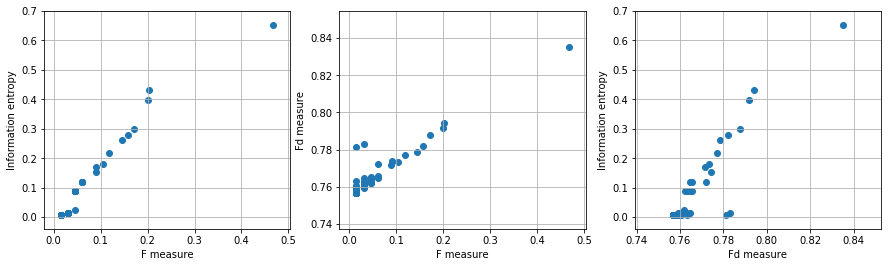

In [8]:
# Note that the measures are all positively correlated
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.scatter(F, entropy)
ax1.set_xlabel("F measure")
ax1.set_ylabel("Information entropy")

ax2 = fig.add_subplot(132)
ax2.scatter(F, Fd)
ax2.set_xlabel("F measure")
ax2.set_ylabel("Fd measure")

ax3 = fig.add_subplot(133)
ax3.scatter(Fd, entropy)
ax3.set_xlabel("Fd measure")
ax3.set_ylabel("Information entropy")

ax1.grid()
ax2.grid()
ax3.grid()

# Identify Key Players for Information Flow
In this section, we identify a set of key players that are central for information flow within the network. This implies that without them, communication within the network is disrupted effectively. Metrics that help us evaluate this property include (all normalized):
- (group) degree centrality
- (group) closeness centrality
- (group) betweenness centrality

Source: http://steveborgatti.com/papers/cmotkeyplayer.pdf

In [9]:
# Degree centrality
degrees = np.sum(largest_cc_inv,axis=1) / largest_cc_inv.shape[0]

# convert adjacency matrix to networkx graph object
G = nx.from_numpy_matrix(largest_cc_inv)

# Closeness centrality
closeness = np.array(list(nx.closeness_centrality(G).values()))

# Betweenness centrality
between = np.array(list(nx.betweenness_centrality(G).values()))

### Boxplots visualization of centrality measures

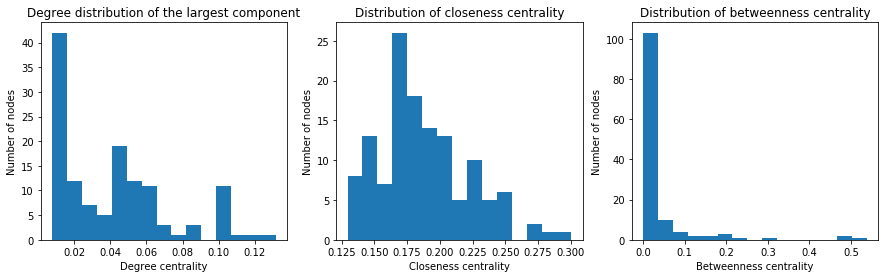

In [10]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.hist(degrees, bins=15)
ax1.set_xlabel("Degree centrality")
ax1.set_ylabel("Number of nodes")
ax1.set_title("Degree distribution of the largest component")

ax2 = fig.add_subplot(132)
ax2.hist(closeness, bins=15)
ax2.set_xlabel("Closeness centrality")
ax2.set_ylabel("Number of nodes")
ax2.set_title("Distribution of closeness centrality")

ax3 = fig.add_subplot(133)
ax3.hist(between, bins=15)
ax3.set_xlabel("Betweenness centrality")
ax3.set_ylabel("Number of nodes")
ax3.set_title("Distribution of betweenness centrality")
plt.show()

### Indicator variables

In [11]:
## Identify nodes which have edges with a specific relations label
#nodes_fam = list((set(np.where(relations_largest_cc == -2)[0])))
#nodes_cong = list((set(np.where(relations_largest_cc == -1)[0])))
#nodes_coll = list((set(np.where(relations_largest_cc == 1)[0])))
#nodes_cont = list((set(np.where(relations_largest_cc == 2)[0])))

## Create indicator variables for each relations label
#ind_fam = np.zeros(largest_cc_inv.shape[0])
#ind_cong = np.zeros(largest_cc_inv.shape[0])
#ind_coll = np.zeros(largest_cc_inv.shape[0])
#ind_cont = np.zeros(largest_cc_inv.shape[0])

#ind_fam[nodes_fam] = 1
#ind_cong[nodes_cong] = 1
#ind_coll[nodes_coll] = 1
#ind_cont[nodes_cont] = 1

### Determine if any of centrality measures are positively correlated

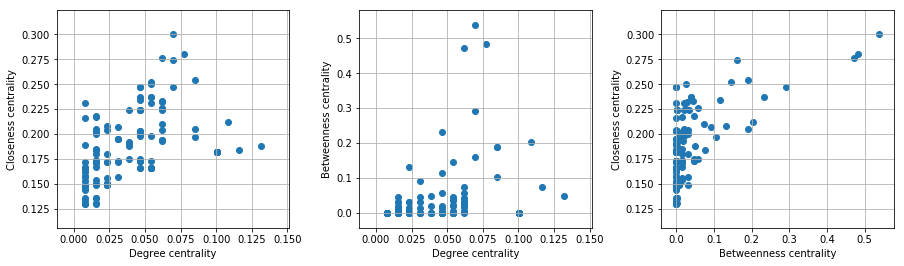

In [12]:
# Note that only betweenness and closeness centralities are (relatively) positively correlated

fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.scatter(degrees, closeness)
ax1.set_xlabel("Degree centrality")
ax1.set_ylabel("Closeness centrality")

ax2 = fig.add_subplot(132)
ax2.scatter(degrees, between)
ax2.set_xlabel("Degree centrality")
ax2.set_ylabel("Betweenness centrality")

ax3 = fig.add_subplot(133)
ax3.scatter(between, closeness)
ax3.set_xlabel("Betweenness centrality")
ax3.set_ylabel("Closeness centrality")

plt.subplots_adjust(wspace=0.3)

ax1.grid()
ax2.grid()
ax3.grid()

# Greedy Optimization Algorithm

In [134]:
from copy import deepcopy

def find_key_terrorists_fragmentation(adjacency):
    """
    Parameters
    ----------
    adjacency: numpy matrix representing the adjacency matrix of the network.
    
    Returns
    -------
    set_kt: list of indices corresponding to key terrorists in order of decreasing importance
    objective: list of cumulative values of the objective function with each additional key terrorist
    """
    
    # initialize the lists of key terrorists and objective values
    set_kt = []
    objective = [] # cumulative

    # compute metric
    score = F_measure(adjacency)

    # relative size of penalty for including more key terrorists
    C = 0.15
    
    # maximize objective function and store its value
    best_score = max(score) - C*(len(set_kt) + 1)
    objective.append(best_score)

    # find key terrorist
    key = np.argmax(score)

    # initialize objective value
    current = -float('inf')

    # create deep copy of original network
    new_adjacency = deepcopy(adjacency)

    # need this to match identify terrorists later
    original_indices = np.array(range(adjacency.shape[0]))

    while current < objective[-1]:
        # update current objective value
        current = objective[-1]

        # If the adjacency has been reduced to size 1
        if new_adjacency.shape[0] == 1:
            # store the last key terrorist
            set_kt.append(original_indices[key])
            original_indices = np.delete(original_indices, original_indices[key])

            # default values
            score = 1
            key = 0
            best_score = score - C*(len(set_kt) + 1)
            objective.append(best_score + objective[-1])
            break

        # remove the key terrorist
        new_adjacency[key,:] = 0
        new_adjacency[:,key] = 0
        zero_index = np.where(np.sum(new_adjacency, axis=0) == 0)[0]
        new_adjacency = np.delete(new_adjacency, zero_index, axis=0)
        new_adjacency = np.delete(new_adjacency, zero_index, axis=1)

        # update set of key terrorists
        set_kt.append(original_indices[key])
        original_indices = np.delete(original_indices, original_indices[key])

        # find the next key terrorist
        score = F_measure(new_adjacency)
        key = np.argmax(score)

        # store optimal objective value (cumulative)
        best_score = max(score) - C*(len(set_kt) + 1)
        objective.append(best_score + objective[-1]) 
    return set_kt, objective

set_kt, objective = find_key_terrorists_fragmentation(largest_cc_inv)

Number of key terrorists for fragmentation: 4
List of the names of the key terrorists for fragmentation: 
 ['/2005/10/20/19:57:58' 'Mohamed_el_Bousklaoui' 'HassanNasrallah'
 'Lionel_Dumont']


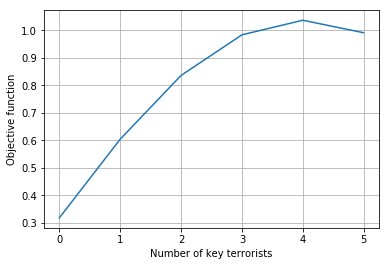

In [135]:
print("Number of key terrorists for fragmentation: {n:}".format(n=len(set_kt)-1))
print("List of the names of the key terrorists for fragmentation: \n", all_names[set_kt[:-1]])

plt.plot(objective)
plt.xlabel("Number of key terrorists")
plt.ylabel("Objective function")
plt.grid()
plt.show()

### TO DO:

Tasks to do: 

    - Exploration of the network: 
        - Give info (numbers) of the current network. What's important from it? Why can we work with the largest component? Whatever useful info we can say about it.

    - Network Fragmentation:
        - Display network before fragmentation and identify (color, tag, etc.) the key players.
        - Display network without key players.
        - Give information about the "destruction" of the network.
            - How many components do we have now?
            - How many links are removed? What's the type of relation is being broken (from the initial information of the dataset)
            - How hard is it to get to these key players? (Give some info about them are their neighborhood)
            
     - Information flow:
         - Identify key players in information flow. --> Run optimization algorithm on information metrics, find best/most useful metric
         - Study diffusion on initial network. 
         - Study diffusion in the network when information is fed through these guys. 
         - Give information about these key players